# TREE OF THOUGHT REASONING

This notebook is an example of how to use tree of thought to solve reasoning based problems better.

In [51]:
#!pip install python-dotenv
#!pip install Groq
import os
from dotenv import load_dotenv
from groq import Groq
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [24]:
# Load the GROQ API KEY

load_dotenv()

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# **FUNCTIONS FOR THOUGHT GENERATION AND EVALUATION**

In [25]:
# call_llm function is used to call the LLM
# :param prompt: The prompt to send to the LLM
# :return: The response from the LLM
def call_llm(prompt):

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": "You are a world class reasoning expert. You are given a reasoning problem to solve. This is your problem:" + prompt,
            }
        ],
        model="llama-3.3-70b-versatile",
    )

    return chat_completion.choices[0].message.content


In [26]:
# generate_thought function is used to generate thoughts for the next step
# :param prompt: The prompt to send to the LLM
# :param step_number: The number of thoughts to generate
# :return: The thoughts from the LLM
def generate_thought(prompt, step_number):

    thought_prompt = f"""
        Given the reasoning problem: "{prompt}", generate {step_number} different 'Thought' options to proceed with the solution step by step.
        Each thought should be short, logical, and explore a different path.

        Format:
        Thought {step_number}.1: ...
        Thought {step_number}.2: ...
        Thought {step_number}.3: ...
    """

    thoughts_text = call_llm(thought_prompt)
    return thoughts_text


In [27]:
# get_all_paths_from_root function is used to get all paths from the root to the leaves
# :param node: The root node of the tree
# :return: All paths from the root to the leaves
def get_all_paths_from_root(node):

    if not node.children:
        return [[node.thought]]

    paths = []
    for child in node.children:
        for subpath in get_all_paths_from_root(child):
            paths.append([node.thought] + subpath)
    return paths

In [28]:
# score_reasoning_path function is used to score a reasoning path
# :param path: The path to score
# :param original_prompt: The original prompt to send to the LLM
# :return: The score of the path
def score_reasoning_path(path, original_prompt):

    joined_reasoning = "\n".join([f"Step {i+1}: {step}" for i, step in enumerate(path)])

    prompt = f"""
        You're evaluating a reasoning path for the problem: "{original_prompt}"

        Here is one possible reasoning path:
        {joined_reasoning}

        Please rate the overall quality and effectiveness of this reasoning path on a scale from 1 to 100.
        Just respond with a number between 1 and 100.
    """

    score_str = call_llm(prompt).strip()
    try:
        return int(score_str)
    except ValueError:
        return 0  # fallback if model responds weirdly

In [29]:
# summarize_best_path function is used to summarize the best path
# :param prompt: The original prompt to send to the LLM
# :param path: The best path to summarize
# :return: The summarized path
def summarize_best_path(prompt, path):

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"Given the prompt: {prompt}, summarize the best reasoning path as precisely and simply as possible \
                    and give the final answer. The reasoning path is: {path}.",
            }
        ],
        model="llama-3.3-70b-versatile",
    )

    return chat_completion.choices[0].message.content


In [30]:
# ThoughtNode class is used to represent a node in the tree of thought
# It contains the thought, the parent node, and the children nodes
# The thought is the content of the node
# The parent node is the node that comes before this node
# The children nodes are the nodes that come after this node
class ThoughtNode:
    def __init__(self, thought, parent=None, score=None):
        self.thought = thought
        self.parent = parent
        self.children = []

    def add_child(self, child_node):
        self.children.append(child_node)

# **FUNCTIONS FOR THE BREADTH-FIRST-SEARCH (BFS) IMPLEMENTATION OF THE TREE OF THOUGHT REASONING**

In [31]:
# bfs_reasoning_solver_full_tree function is used to solve the reasoning problem
# :param user_prompt: The prompt to send to the LLM
# :param max_depth: The maximum depth of the tree
# :param thoughts_per_step: The number of thoughts to generate for each step
# :return: The root node of the tree
def bfs_reasoning_solver_full_tree(user_prompt, max_depth=5, thoughts_per_step=3):

    root = ThoughtNode(thought=user_prompt)
    queue = deque([root])  # BFS queue

    for depth in range(max_depth):
        print(f"\nStep {depth + 1} — Expanding {len(queue)} node(s)...")
        current_level_nodes = list(queue)
        queue.clear()

        for node in current_level_nodes:
            print(f"\nExpanding:\n→ {node.thought}")

            thoughts_text = generate_thought(node.thought, step_number=thoughts_per_step)
            print(f"\nGenerated Thoughts:\n{thoughts_text}")

            for line in thoughts_text.splitlines():
                if line.strip().startswith(f"Thought {thoughts_per_step}."):
                    thought_content = line.split(":", 1)[-1].strip()
                    child_node = ThoughtNode(thought=thought_content, parent=node)
                    node.add_child(child_node)
                    queue.append(child_node)

    return root


# **FUNCTIONS FOR THE DEPTH-FIRST-SEARCH (DFS) IMPLEMENTATION OF THE TREE OF THOUGHT REASONING**

In [32]:
# dfs_expand function is used to expand the tree of thought
# :param node: The current node
# :param current_depth: The current depth of the tree
# :param max_depth: The maximum depth of the tree
# :param thoughts_per_step: The number of thoughts to generate for each step
# :return: None
def dfs_expand(node, current_depth, max_depth, thoughts_per_step):
    if current_depth >= max_depth:
        return

    print(f"\nExpanding (depth {current_depth}):\n→ {node.thought}")
    thoughts_text = generate_thought(node.thought, step_number=thoughts_per_step)
    print(f"\nGenerated Thoughts:\n{thoughts_text}")

    for line in thoughts_text.splitlines():
        if line.strip().startswith(f"Thought {thoughts_per_step}."):
            thought_content = line.split(":", 1)[-1].strip()
            child_node = ThoughtNode(thought=thought_content, parent=node)
            node.add_child(child_node)
            dfs_expand(child_node, current_depth + 1, max_depth, thoughts_per_step)


In [33]:
# dfs_reasoning_solver_full_tree function is used to solve the reasoning problem
# :param user_prompt: The prompt to send to the LLM
# :param max_depth: The maximum depth of the tree
# :param thoughts_per_step: The number of thoughts to generate for each step
# :return: The root node of the tree
def dfs_reasoning_solver_full_tree(user_prompt, max_depth=5, thoughts_per_step=3):
    root = ThoughtNode(thought=user_prompt)
    dfs_expand(root, current_depth=0, max_depth=max_depth, thoughts_per_step=thoughts_per_step)
    return root

# **TESTING OUT THE TREE OF THOUGHT!!**

In [38]:
# tree_of_thought function solves the user's reasoning problem based on
# tree_of_thought approach and prints the solution
# :Param None:
# :return: None

def tree_of_thought():
  global root, best_path

  if mode == "bfs":
    root = bfs_reasoning_solver_full_tree(reasoning_prompt, max_depth=3, thoughts_per_step=3)

  else:
    root = dfs_reasoning_solver_full_tree(reasoning_prompt, max_depth=3, thoughts_per_step=3)

  all_paths = get_all_paths_from_root(root)
  print(f"\nFound {len(all_paths)} reasoning paths.\n")

  for i, path in enumerate(all_paths, start=1):
      print(f"Path {i}:")
      for j, step in enumerate(path, start=1):
          print(f"  Step {j}: {step}")
      print("---------------")

  best_score = -1

  print("\nScoring all reasoning paths...\n")

  for i, path in enumerate(all_paths, start=1):
      score = score_reasoning_path(path, reasoning_prompt)
      print(f"Path {i}: Scored {score}/100")

      if score > best_score:
          best_score = score
          best_path = path

  # Show the best path
  print("\nBest Reasoning Path:")
  for i, step in enumerate(best_path, 1):
      print(f"Step {i}: {step}")
  print(f"\nFinal Score: {best_score}/100")

  print("\nThe solution is...")
  print(summarize_best_path(reasoning_prompt, best_path))

In [39]:
# "bfs" or "dfs"
mode = "bfs"

# Your prompt here...
reasoning_prompt = "A snail is stuck at the bottom of a 10-meter well. \
During the day, it climbs up 3 meters, but each night, it slides back down \
2 meters. How many days will it take for the snail to reach the top of the well?"

tree_of_thought()


Step 1 — Expanding 1 node(s)...

Expanding:
→ A snail is stuck at the bottom of a 10-meter well. During the day, it climbs up 3 meters, but each night, it slides back down 2 meters. How many days will it take for the snail to reach the top of the well?

Generated Thoughts:
Thought 3.1: Let's break down the daily progress of the snail. If it climbs 3 meters during the day and slides back 2 meters at night, it effectively moves 1 meter up each day. We can calculate the number of days it takes to climb 8 meters (10 - 2, considering the final 2 meters it will climb in the last day without sliding back), as on the 8th meter, when it climbs the final 2 meters, it will reach the top without sliding back.

Thought 3.2: Consider using a formulaic approach. The snail's net progress each day is 3 meters (up) - 2 meters (down) = 1 meter per day. However, on the last day of climbing, the snail won't slide back, as it will have reached or surpassed the top of the well. We can set up an equation whe

**VISUALIZATION OF THE SOLUTION TREE**

In [47]:
def visualize_tree_with_best_path(root_node, best_path, max_children=3):
    import networkx as nx
    import matplotlib.pyplot as plt
    from networkx.drawing.nx_agraph import graphviz_layout

    G = nx.DiGraph()
    labels = {}
    best_path_nodes = set()

    # Match best path node references based on thought text
    def match_best_path(root, best_path):
        path_nodes = []
        current_node = root
        for step_text in best_path[1:]:  # Skip root
            for child in current_node.children:
                if child.thought == step_text:
                    path_nodes.append(child)
                    current_node = child
                    break
        return path_nodes

    best_path_nodes = set([id(n) for n in match_best_path(root_node, best_path)])

    # Build the graph and limit children per node
    def add_edges(node):
        labels[id(node)] = node.thought[:40] + ("..." if len(node.thought) > 40 else "")
        children_to_show = node.children[:max_children]  # limit here
        for child in children_to_show:
            G.add_edge(id(node), id(child))
            add_edges(child)

    add_edges(root_node)

    try:
        pos = graphviz_layout(G, prog="dot")
    except Exception as e:
        print("⚠️ Graphviz layout failed:", e)
        print("Falling back to spring layout")
        pos = nx.spring_layout(G, k=0.9, seed=42)

    node_colors = [
        "lightgreen" if node in best_path_nodes else "lightblue"
        for node in G.nodes
    ]

    plt.figure(figsize=(14, 10))
    nx.draw(G, pos, with_labels=False, arrows=True, node_size=1600, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    plt.title(f"Tree of Thought (Top {max_children} Branches per Node)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


⚠️ Graphviz layout failed: requires pygraphviz http://pygraphviz.github.io/
Falling back to spring layout


<ipython-input-47-198f8935f988>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


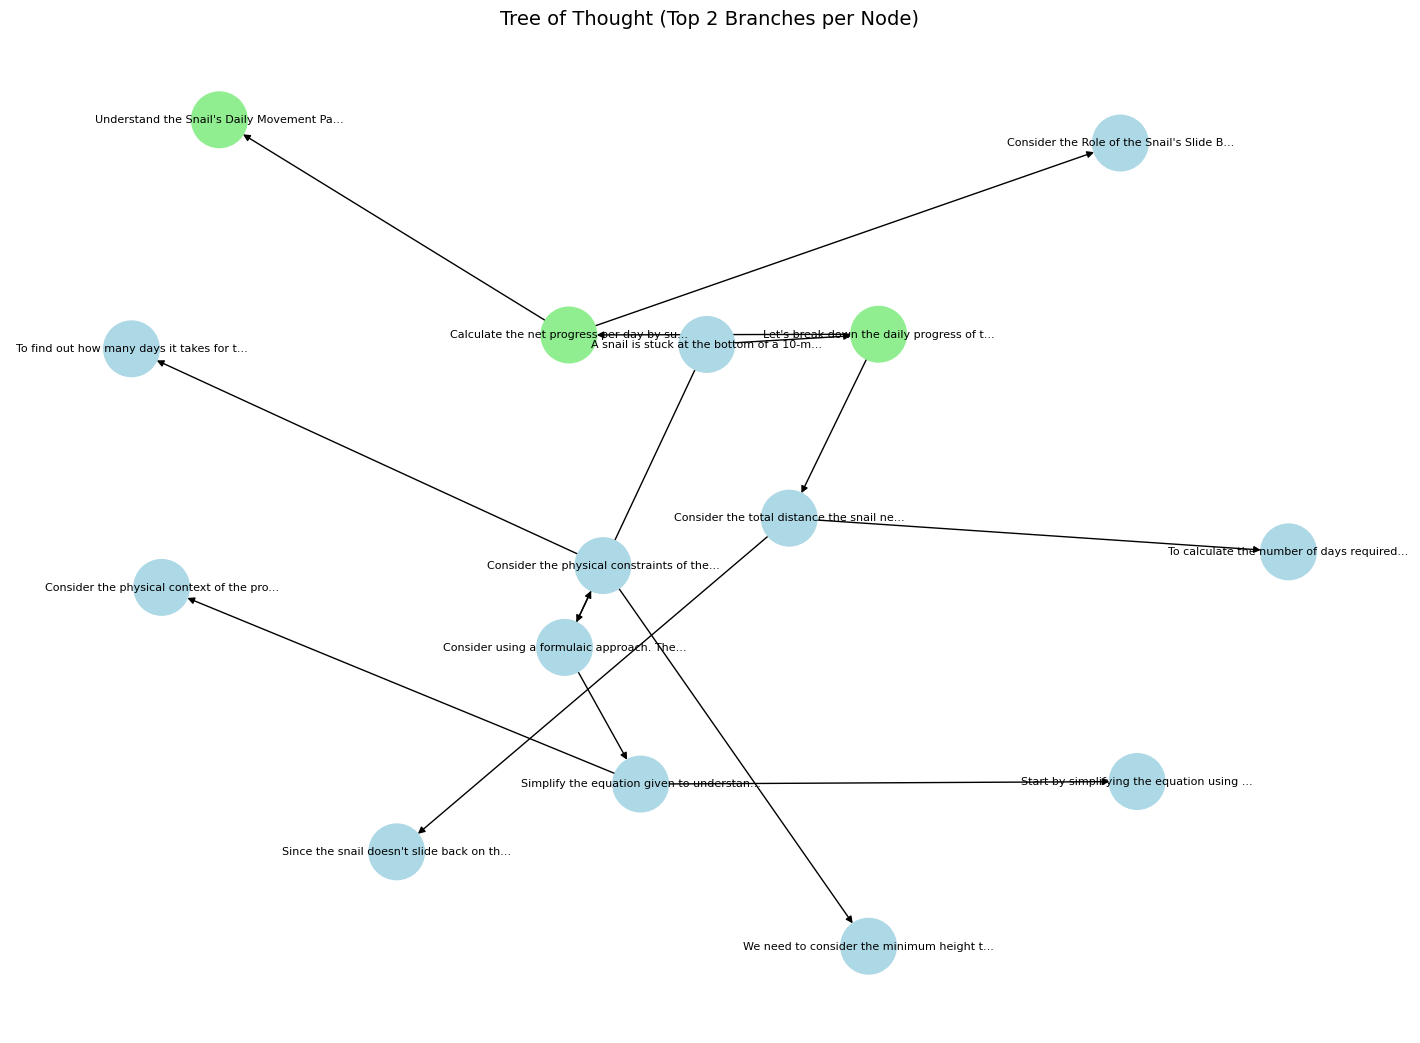

In [50]:
visualize_tree_with_best_path(root, best_path, 2)